# <center><u>Building Recommendation Model Based on User Reviews</u></center>

### Data Description:
Online E-commerce websites like Amazon, Flipkart uses different recommendation models to provide different suggestions to different users. Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.
### File Name: 
ratings_Electronics.csv
### Objective:
Build a recommendation system to recommend products to customers based on the their previous ratings for other products.
### Analysis By:
Soumalya Biswas (Group-3)

# ============================================================

### Importing the necessary libraries to analyse data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import datetime

# Called surprise library packages
from surprise import Dataset, Reader, accuracy, KNNWithMeans, SVD, KNNBasic, BaselineOnly, SVDpp
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV, KFold

# Called collections library
from collections import defaultdict

<b>Comment:</b> 
* Importing the pandas library to access the dataframe.
* For graphical representation I used seaborn and matplotlib.
* Numpy library used to calculate and access array
* time and datetime library used to the time measurement informations
* For model building we used some packages of surprise libraries `Dataset`, `Reader`, `accuracy`, `KNNWithMeans`, `SVD`, `KNNBasic`, `BaselineOnly`.
* For spliting coss validation and hyper tuning purpose we used some packages of surprise.model_selection libraries `train_test_split`, `cross_validate`, `GridSearchCV`, `KFold`.
* For large dictionary creation purpose using `defaultdict` library of `collections`

### Reading the data as a data frame

In [2]:
dataset_df = pd.read_csv('ratings_Electronics.csv', names=['userId', 'productId', 'rating', 'timestamp'])
dataset_df.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [3]:
dataset_df['rating'].unique()

array([5., 1., 3., 2., 4.])

<b>Comment:</b> Read the data from vehicle.csv file using pandas function called read_csv and stored the dataframe in variable named dataset_df. Also displayed the first 5 row of the data from dataframe using head function.

### Understanding of Data Attributes
  Checked the dataset separately with excel editor. Added filter in each column to understand the nature of the data.
  
<b><u>Interval Vriables :</u></b>
  * <b>rating : </b> Rating of the corresponding product by the corresponding user.
  * <b>timestamp : </b> Time of the rating(ignore this column for this exercise).
  
<b><u>Ordinal Categorical Variables :</u></b>
  * <b>userId : </b> Every user identified with a unique id.
  * <b>productId : </b> Every product identified with a unique id.

### Performing the basic EDA

* <b><u>Shape of the data</u></b>

In [4]:
rows, columns = dataset_df.shape
print(f'There are {rows} rows and {columns} columns in the dataframe.')

There are 7824482 rows and 4 columns in the dataframe.


* <b><u>Checking the length of the index of the data</u></b>

In [5]:
len(dataset_df.index)

7824482

<b>Comment:</b> Found the row size and the index sizes are equal which is 7824482 in the dataset against the columns size 4.

* <b><u>Checking the data type of each attribute</u></b>

In [6]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
userId       object
productId    object
rating       float64
timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [7]:
dataset_df.dtypes

userId        object
productId     object
rating       float64
timestamp      int64
dtype: object

<b>Comment: </b> I can see out of 4 column there is 2 object values column and 1 Discrete Variable value and 1 continueous variable value column available.
 *  1 Float type (`rating`)
 *  1 Integer type (`timestamp`)
 *  2 Object Type (`userId`, `productId`)

* <b><u>Checking the unique value</u></b>

In [8]:
dataset_df.apply(lambda x: len(x.unique()))

userId       4201696
productId     476002
rating             5
timestamp       5489
dtype: int64

<b>Comment : </b> For checking the unique value I used unique function of pandas and applied through the dataframe with the helpof lambda function.
 
 * Only `rating` is having multiple categorical values. Rating 1 to 5. But We are going to keep this value as continuous value.
 * `userId` and `productId` are having unique values, `userId` is having `4201696` unique users and `productId` is having `476002` unique products in the dataset.

* <b><u>Checking the presence of missing values</u></b>

In [9]:
dataset_df.isnull().values.any()

False

In [10]:
dataset_df.isna().values.any()

False

In [11]:
dataset_df.isnull().sum()

userId       0
productId    0
rating       0
timestamp    0
dtype: int64

In [12]:
dataset_df.isna().sum()

userId       0
productId    0
rating       0
timestamp    0
dtype: int64

<b>Comment:</b> I found there is no missing values in the dataframe. For that I used isnull and isna function of dataframe and there I checked if any isnull or isna values present or not. I found False return. And also checked the sum of null and sum of na values on each attribute which is 0 in our dataset.

Also for more evidence, if I look at the above info function output it's showing me all equal distribution of rows in between different data types. So, I can say there is no missing values in this dataset.

* <b><u>Key Characteristics of Numerical data</u></b>

In [13]:
five_points_summury = dataset_df.describe().T
five_points_summury

,count,mean,std,min,25%,50%,75%,max
rating,7824482.0,4.012337e+00,1.380910e+00,1.0,3.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
timestamp,7824482.0,1.338178e+09,6.900426e+07,912729600.0,1.315354e+09,1.361059e+09,1.386115e+09,1.406074e+09


So `rating` is the only attribute which keeps the impact for our objective. And after looking at the summary of the data I can see - 
 * Mean value and the median value have soome difference.
 * With rating 5, this dataset is having more datas where mean is rating 4.
 * Even 3rd inter Quartile or 75% of the data is also rating 5.

* <b><u>5 point summary of numerical attributes</u></b>

In [14]:
five_points_summury[['min','25%','50%','75%','max']]

,min,25%,50%,75%,max
rating,1.0,3.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
timestamp,912729600.0,1.315354e+09,1.361059e+09,1.386115e+09,1.406074e+09


<b>Comment:</b> I used describe function of dataframe to determine the 5 point summary of numerical attributes. Applied transpose to the result and stored in a variable called five_points_summury.

Here We can see the key characteristics of our numerical datas like mean, standard deviation  of attributes. 

Then I displayed the 5 point summury where some important insights I found like min and max values of numerical attributes which will help me in my next analysis.



### Outlier Checking

Used seaborn boxplot function to observe and display the outliers

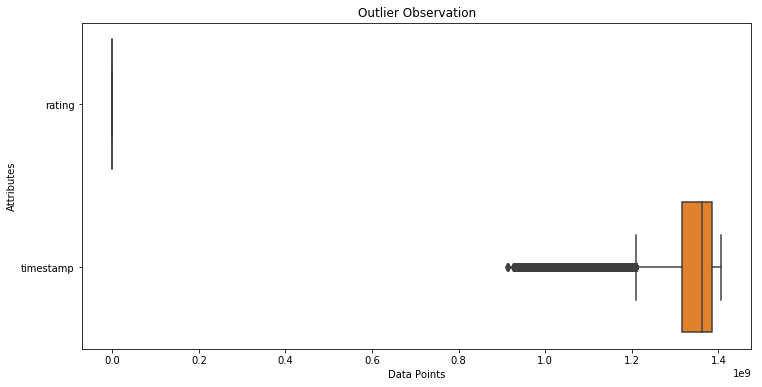

In [15]:
plt.figure(figsize=(12,6))
sns.boxplot(data=dataset_df, orient='h')
plt.title('Outlier Observation')
plt.xlabel('Data Points')
plt.ylabel('Attributes')
plt.show()

<b>Comment: </b> From the above ploting I can say `timestamp` column is the only column having clear outliers. But we are not going to use this attribute for our model building. So outlier anyway does not effect our model. 


<u>From above individual box plot graph,</u><br>
 a. Bottom black horizontal line of box plot is minimum value.<br>
 b. First black horizontal line of rectangle shape of box plot is First quartile or 25%<br>
 c. Second black horizontal line of rectangle shape of box plot is Second quartile or 50% or median.<br>
 d. Third black horizontal line of rectangle shape of box plot is third quartile or 75%<br>
 e. Top black horizontal line of rectangle shape of box plot is maximum value.<br>
 f. Small diamond shape of box plot is <b>outlier data</b>.

### Relation between Individual attributes

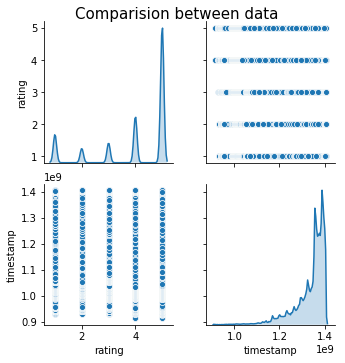

This took 176.88 seconds


In [16]:
startTimestamp = time.time()
sns.pairplot(dataset_df, diag_kind='kde')
plt.suptitle('Comparision between data', y=1,size=15)
plt.show()
endTimestamp = time.time()
print("This took %.2f seconds" % (endTimestamp - startTimestamp))

<b> Comment: </b> I used seaborn pairplot function to check the relation between individual attributes.

We are getting pairplot of numeric attributes.

<b> Few interesting facts: </b>
- From the above pairplot we can see clear 5 individual ratings.
- Rating 5, rating 4, rating 1, rating 3, rating 2. These the rating sorted in high to low based on data distribution. 


### Rating Distribution

In [17]:
rating_counts = pd.DataFrame({'Labels': ['Rating 5','Rating 4','Rating 1','Rating 3','Rating 2'], 'rating': dataset_df["rating"].value_counts(),'Percentage (%)': dataset_df["rating"].value_counts(normalize=True).mul(100)})
rating_counts

,Labels,rating,Percentage (%)
5.0,Rating 5,4347541,55.563308
4.0,Rating 4,1485781,18.988874
1.0,Rating 1,901765,11.524916
3.0,Rating 3,633073,8.090925
2.0,Rating 2,456322,5.831977


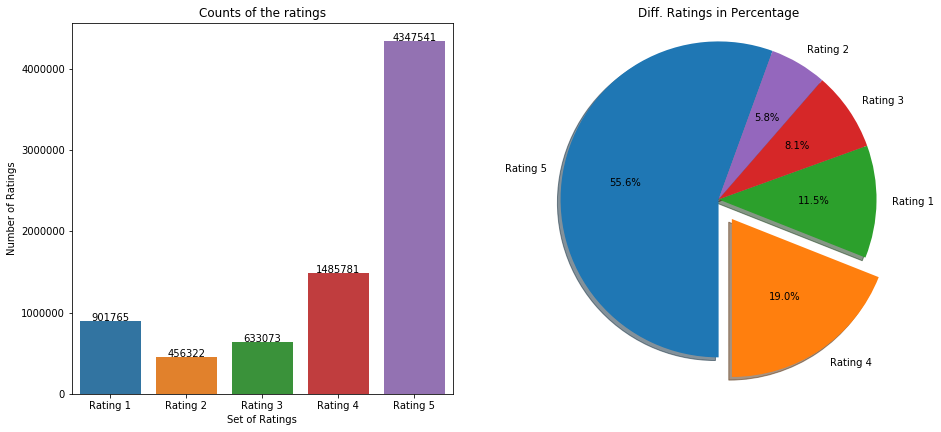

In [18]:
fig1 = plt.figure(figsize=(15,15))
fig1.add_subplot(2,2,1)
ax = sns.countplot(x="rating", data=dataset_df)
plt.title('Counts of the ratings')
plt.xlabel('Set of Ratings')
plt.ylabel('Number of Ratings')
ax.set_xticklabels(['Rating 1','Rating 2','Rating 3','Rating 4','Rating 5'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.3,height ,ha="center")

fig1.add_subplot(2,2,2)
explode = (0, 0.15, 0, 0, 0)
plt.pie(rating_counts["rating"], explode=explode, labels=rating_counts["Labels"], autopct='%1.1f%%',
        shadow=True, startangle=70)
plt.axis('equal')
plt.title("Diff. Ratings in Percentage")
plt.show()

From the above graphs, clearly I can see the no. of rating distribution is 
 * Rating 1 - 901765 
 * Rating 2 - 456322
 * Rating 3 - 633073
 * Rating 4 - 1485781
 * Rating 5 - 4347541

I used seaborn countplot and pie chart function to display that.

### Checking the hidden patterns from the dataset

<b>Distribution of ratings</b>

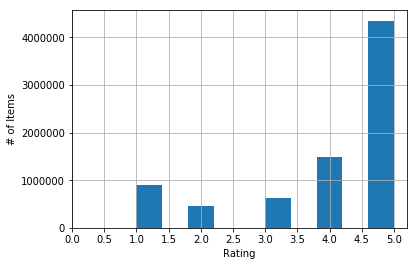

In [19]:
# now lets plot a histogram of item ratings to get an overall picture
plt.hist(dataset_df.rating)
plt.xticks([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
plt.xlabel('Rating')
plt.ylabel('# of Items')
plt.grid()
plt.show()

<b> Comment: </b> Above graph is the histogram plot to display the rating distribution/count. It's clear that the Rating 5 is having the highest number which user used to give.


In [20]:
# defination to extract the year from timestamp
def convTimeToYear(timestamp):
    timestamp = datetime.date.fromtimestamp(timestamp)
    return timestamp.year

dataset_df['year'] = dataset_df['timestamp'].apply(convTimeToYear)
dataset_df

,userId,productId,rating,timestamp,year
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200,2013
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800,2012
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600,2013
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200,2013
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200,2012
5,A1QGNMC6O1VW39,0511189877,5.0,1397433600,2014
6,A3J3BRHTDRFJ2G,0511189877,2.0,1397433600,2014
7,A2TY0BTJOTENPG,0511189877,5.0,1395878400,2014
8,A34ATBPOK6HCHY,0511189877,5.0,1395532800,2014
9,A89DO69P0XZ27,0511189877,5.0,1395446400,2014


<b>Checking the Rating count distribution year wise</b>

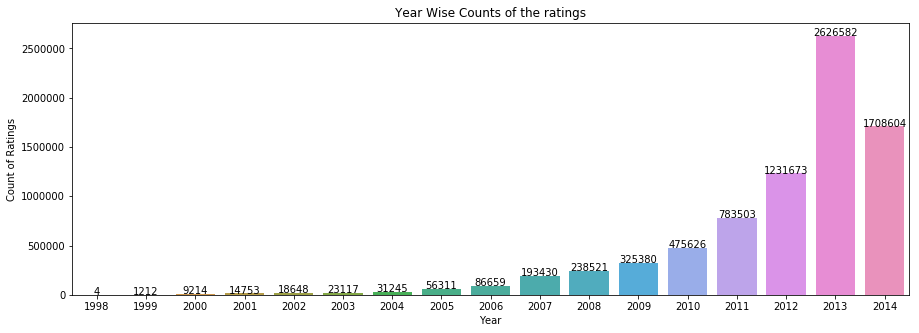

In [21]:
fig1 = plt.figure(figsize=(15,5))
ax = sns.countplot(x="year", data=dataset_df)
plt.title('Year Wise Counts of the ratings')
plt.xlabel('Year')
plt.ylabel('Count of Ratings')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.3,height ,ha="center")
plt.show()

<b> Comment: </b> In year <b>2013</b> users posted most ratings. The count is `2626582`. Then year <b>2014</b>: `1708604` then after as the year decreases ratings count also decreses. 

This graph also define another strong statement that <b>the use of internet and online shopping progresses more day by day</b>.

<b>Year Wise Individual Rating Distribution : </b>

Displayed only last 8 years (2007-2014) distribution as before 2007 there is very less count of ratings we have. 

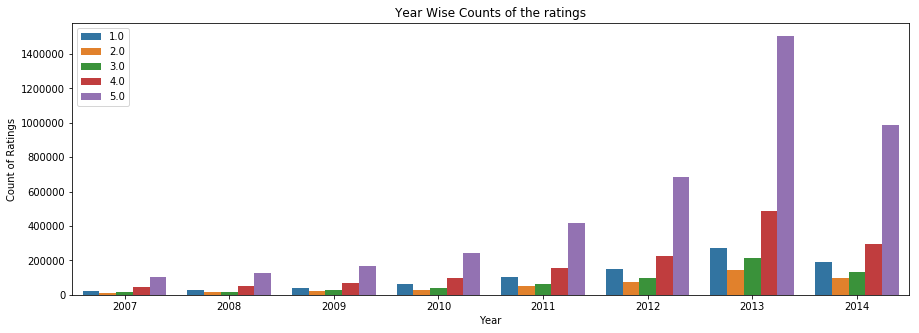

In [22]:
fig1 = plt.figure(figsize=(15,5))
ax = sns.countplot(x="year", data=dataset_df[dataset_df['year'] > 2006], hue='rating')
plt.title('Year Wise Counts of the ratings')
plt.xlabel('Year')
plt.ylabel('Count of Ratings')
plt.legend(loc='upper left')
plt.show()

<b> Comment: </b> We can clearly state few facts from the above graph - 

* People tends to give high rating on the products.
* Most user ratings are `Rating 5`, `Rating 4` and `Rating 1`.
* `Rating 2` is the least counted rating which people provides. 

<hr>

### Corelation checking

* Checking the corelation using pandas corr() function

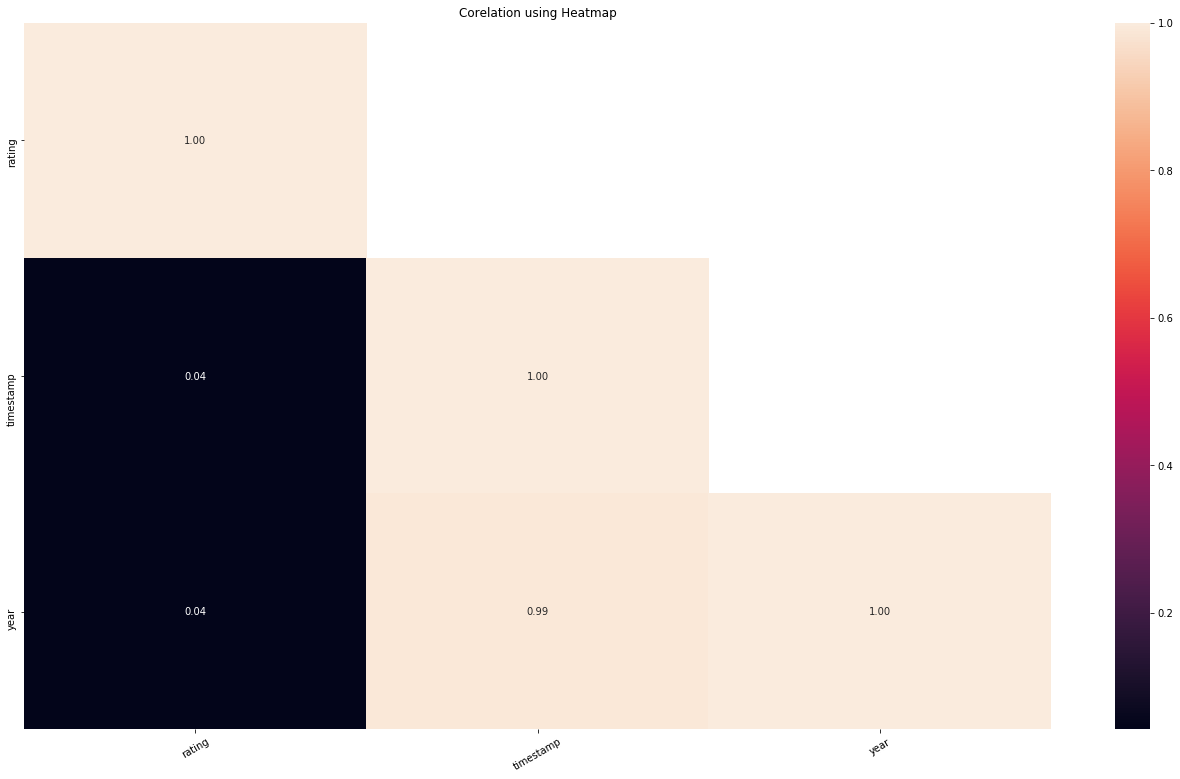

In [23]:
corr = dataset_df.corr()
plt.figure(figsize=(23,13))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True
hmap = sns.heatmap(corr,mask=mask, annot=True, fmt='.2f')
hmap.set_xticklabels(hmap.get_xticklabels(), rotation=30)
plt.title('Corelation using Heatmap')
plt.show()

<b>Comment: </b> Only value we have is between rating and timestamp. And there is no corelation between these two attributes. `timestamp` and `year` has the high positive corelation as year extracted from timestamp. 

But we will anyway going to remove these two attributes `timestamp` and `year`.

<hr>

## Data Preprocessing

<b><u>Dropping timestamp attribute</u></b>

In [24]:
# dropping colum
dataset_df_wo_time = dataset_df.drop(['timestamp','year'], axis=1)
print(f"Shape of this dataframe {dataset_df_wo_time.shape} ")
dataset_df_wo_time.head()

Shape of this dataframe (7824482, 3) 


,userId,productId,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


<b><u>Filtering data points for the users who have given 50 or more than 50 ratings</u></b>

In [25]:
# Creating a new column 'ratingCounts' and merging it to the our dataframe
rating_counts = dataset_df_wo_time['userId'].value_counts().rename('ratingCounts')
dataset_df_with_rating_count = dataset_df_wo_time.merge(rating_counts.to_frame(), left_on='userId', right_index=True)
dataset_df_with_rating_count.sort_values(by=['ratingCounts'], ascending=False)

,userId,productId,rating,ratingCounts
555028,A5JLAU2ARJ0BO,B00068E1ME,1.0,520
140372,A5JLAU2ARJ0BO,B0000659UN,5.0,520
635726,A5JLAU2ARJ0BO,B0007YN3F8,3.0,520
632790,A5JLAU2ARJ0BO,B0007XXU2K,4.0,520
632003,A5JLAU2ARJ0BO,B0007XO7AE,4.0,520
631958,A5JLAU2ARJ0BO,B0007XO79U,4.0,520
628496,A5JLAU2ARJ0BO,B0007WZMW2,5.0,520
622698,A5JLAU2ARJ0BO,B0007UVYO4,5.0,520
622661,A5JLAU2ARJ0BO,B0007UVYLC,5.0,520
618699,A5JLAU2ARJ0BO,B0007TZNA6,2.0,520


In [26]:
# Adding conditions for users given 50 or more than 50 ratings
dataset_df_with_rating_count = dataset_df_with_rating_count[dataset_df_with_rating_count.ratingCounts >= 50]
dataset_df_with_rating_count.sort_values(by=['ratingCounts'], ascending=False)

,userId,productId,rating,ratingCounts
4466321,A5JLAU2ARJ0BO,B004TKTOWC,4.0,520
555028,A5JLAU2ARJ0BO,B00068E1ME,1.0,520
635726,A5JLAU2ARJ0BO,B0007YN3F8,3.0,520
632790,A5JLAU2ARJ0BO,B0007XXU2K,4.0,520
632003,A5JLAU2ARJ0BO,B0007XO7AE,4.0,520
631958,A5JLAU2ARJ0BO,B0007XO79U,4.0,520
628496,A5JLAU2ARJ0BO,B0007WZMW2,5.0,520
622698,A5JLAU2ARJ0BO,B0007UVYO4,5.0,520
622661,A5JLAU2ARJ0BO,B0007UVYLC,5.0,520
618699,A5JLAU2ARJ0BO,B0007TZNA6,2.0,520


<b> Comments: </b> So we filter out the ratings based on 50 or more than 50 ratings given by users and saved tha dataset on new datafram called `dataset_df_with_rating_count`.

In [27]:
# Checking for the counts of the products with rating 5
df_group_product = dataset_df_with_rating_count[dataset_df_with_rating_count['rating'] > 4].groupby(['productId','rating'])
df_group_product['rating'].count()

productId   rating
0594451647  5.0        1
0972683275  5.0        3
1400501466  5.0        3
1400501520  5.0        1
1400501776  5.0        1
1400532620  5.0        1
1400532655  5.0        3
1400599997  5.0        3
1400698987  5.0        1
1400699169  5.0        1
1685560148  5.0        1
3744295508  5.0        1
787988002X  5.0        2
8862935307  5.0        1
9573212919  5.0        1
9575871979  5.0        1
9800359788  5.0        1
9981739588  5.0        1
9983722615  5.0        1
9983891212  5.0        7
9984922626  5.0        1
9984984362  5.0        1
9985511476  5.0        1
9989360391  5.0        1
B000000O48  5.0        1
B000001OKH  5.0        1
B000001OM4  5.0        2
B000001OM5  5.0        1
B000001OMI  5.0        1
B000001ON0  5.0        1
                      ..
B00KV6FFN0  5.0        1
B00KVLY8E2  5.0        1
B00KVNY2KA  5.0        9
B00KW2W6B2  5.0        2
B00KW3OFG0  5.0        2
B00KWL62QI  5.0        4
B00KWMNDDM  5.0        3
B00KWPRSJY  5.0        1
B00KWW

<b>Comments : </b> It's quite clear that we have even 1 value for rating 5 on individual products which leads to greysheep problem. So we need to choose the products which is having atleast 10 or more than 10 in counts for ratings.

<b><u>Filtering data points for the products which is having at least 10 or more than 10 ratings counts</u></b>

In [28]:
# Creating a new column 'itemRatingCounts' and merging it to the our dataframe
item_rating_counts = dataset_df_with_rating_count['productId'].value_counts().rename('itemsRatingCounts')
dataset_df_with_item_rating_count = dataset_df_with_rating_count.merge(item_rating_counts.to_frame(), left_on='productId', right_index=True)
dataset_df_with_item_rating_count.sort_values(by=['itemsRatingCounts'], ascending=False)

,userId,productId,rating,ratingCounts,itemsRatingCounts
6106357,A20L63B48RPSOH,B0088CJT4U,4.0,83,206
6105438,A2GOHNFBHUU3UI,B0088CJT4U,5.0,74,206
6105856,A1LD5SE8IZ1H70,B0088CJT4U,5.0,79,206
6105194,A1GW7V6S6XSXX3,B0088CJT4U,3.0,68,206
6105627,A3T8WOFS5RD2IR,B0088CJT4U,5.0,56,206
6106043,A3R1WFO4KIUQXZ,B0088CJT4U,3.0,134,206
6105009,AV8MDYLHHTUOY,B0088CJT4U,4.0,79,206
6105346,A3SMD3T0QTN109,B0088CJT4U,4.0,88,206
6106019,A28UMA3GW9L124,B0088CJT4U,5.0,145,206
6105733,A2JMJVNTBL7K7E,B0088CJT4U,3.0,96,206


In [29]:
# Adding conditions for products with 10 or more than 10 ratings counts
dataset_df_with_item_rating_count = dataset_df_with_item_rating_count[dataset_df_with_item_rating_count.itemsRatingCounts >= 10]
dataset_df_with_item_rating_count.sort_values(by=['itemsRatingCounts'], ascending=False)

,userId,productId,rating,ratingCounts,itemsRatingCounts
6105092,A2NP9CGUSFP22E,B0088CJT4U,5.0,77,206
6105436,ALRCAGJOJ9583,B0088CJT4U,5.0,85,206
6105208,A10ZFE6YE0UHW8,B0088CJT4U,4.0,130,206
6105115,A27QXQQOLAMRRR,B0088CJT4U,4.0,103,206
6106297,ACQYIC13JXAOI,B0088CJT4U,4.0,83,206
6105212,A23R3EOZ837242,B0088CJT4U,5.0,63,206
6105312,A2FWZ58M6IQMD7,B0088CJT4U,3.0,65,206
6105261,A2BLFCOPSMBOZ9,B0088CJT4U,4.0,170,206
6105412,A3J3ZHGDUDPCFL,B0088CJT4U,5.0,53,206
6105692,A33HIV8RXRDM88,B0088CJT4U,4.0,116,206


<b> Comment: </b> So we filter out the ratings based on 10 or more than 10 ratings counts atleast products and saved tha dataset on new datafram called `dataset_df_with_item_rating_count`.

<b><u>Cross Checking the new dataset</u></b>

In [30]:
dataset_df_with_item_rating_count[(dataset_df_with_item_rating_count.ratingCounts < 50) & (dataset_df_with_item_rating_count.itemsRatingCounts < 10)].count()

userId               0
productId            0
rating               0
ratingCounts         0
itemsRatingCounts    0
dtype: int64

In [31]:
# dropping the extra rating counts columns
final_dataset_df = dataset_df_with_item_rating_count.drop(['ratingCounts', 'itemsRatingCounts'], axis=1)
print(f"Shape of this dataframe {final_dataset_df.shape} ")
final_dataset_df.head(10)

Shape of this dataframe (42941, 3) 


,userId,productId,rating
634048,A3BY5KCNQZXV5U,B0007Y794O,5.0
633970,AKT8TGIT6VVZ5,B0007Y794O,5.0
633944,A1ILWPH1GHUXE2,B0007Y794O,4.0
634073,A1ZM846Y7AUYD,B0007Y794O,4.0
633998,A2ED50E3KWKUKW,B0007Y794O,5.0
633825,A4WEZJOIZIV4U,B0007Y794O,5.0
633770,A1O229NVVDJUX2,B0007Y794O,4.0
633802,AGXV8E7XK9J6H,B0007Y794O,4.0
634012,A178M2AHNWQZB0,B0007Y794O,5.0
634134,A2TA40MV2H4O6F,B0007Y794O,4.0


<b> Comment: </b> So finally we got our dataset for model building. We can say it's the best possible data with user and products combination ratings and saved tha dataset on new datafram called `final_dataset_df`.

<hr>

## <center><u>:: Model Building ::</u></center>

<b><u>Initializing the variable for number of recommendation</u></b>

In [32]:
k = 5

<hr>

### <center><u>Popularity Recommender Model</u></center>

#### <u>Regular Sorting Process (Without Algorithm)</u>

In [33]:
# Checking the average of rating of 5 products
final_dataset_df.groupby('productId')['rating'].mean().head()

productId
B00001P4XA    4.000000
B00001P4ZH    4.470588
B00001WRSJ    4.500000
B00001ZWXA    4.600000
B00004SABB    4.000000
Name: rating, dtype: float64

In [34]:
# Sorting the top 5 average rated products
final_dataset_df.groupby('productId')['rating'].mean().sort_values(ascending=False).head()  

productId
B00L3YHF6O    5.0
B00006HSML    5.0
B001TH7GUA    5.0
B000IJY8DS    5.0
B005LDLP8W    5.0
Name: rating, dtype: float64

In [35]:
# Sorting the top 5 average rated products and displaying the counts of the ratings
final_dataset_df.groupby('productId')['rating'].count().sort_values(ascending=False).head()  

productId
B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
Name: rating, dtype: int64

#### <u>Algorithm Based Recommender Process</u>

In [36]:
#Count of user_id for each unique song as recommendation score 
train_data_grouped = final_dataset_df.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head()

,productId,score
0,B00001P4XA,12
1,B00001P4ZH,17
2,B00001WRSJ,16
3,B00001ZWXA,10
4,B00004SABB,13


In [37]:
#Sort the songs on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
  
#Get the top k recommendations 
popularity_recommendations = train_data_sort.head(k) 
popularity_recommendations 

,productId,score,Rank
1592,B0088CJT4U,206,1.0
839,B003ES5ZUU,184,2.0
226,B000N99BBC,167,3.0
1552,B007WTAJTO,164,4.0
1577,B00829TIEK,149,5.0


We got top ranked products counting score wise.

In [38]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [39]:
find_recom = ['A34VRVI4CSI5RQ','AHROSV6WJOEGY','A2G563AC1HME2R']   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %s\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: A34VRVI4CSI5RQ

              userId   productId  score  Rank
1592  A34VRVI4CSI5RQ  B0088CJT4U    206   1.0
839   A34VRVI4CSI5RQ  B003ES5ZUU    184   2.0
226   A34VRVI4CSI5RQ  B000N99BBC    167   3.0
1552  A34VRVI4CSI5RQ  B007WTAJTO    164   4.0
1577  A34VRVI4CSI5RQ  B00829TIEK    149   5.0


Here is the recommendation for the userId: AHROSV6WJOEGY

             userId   productId  score  Rank
1592  AHROSV6WJOEGY  B0088CJT4U    206   1.0
839   AHROSV6WJOEGY  B003ES5ZUU    184   2.0
226   AHROSV6WJOEGY  B000N99BBC    167   3.0
1552  AHROSV6WJOEGY  B007WTAJTO    164   4.0
1577  AHROSV6WJOEGY  B00829TIEK    149   5.0


Here is the recommendation for the userId: A2G563AC1HME2R

              userId   productId  score  Rank
1592  A2G563AC1HME2R  B0088CJT4U    206   1.0
839   A2G563AC1HME2R  B003ES5ZUU    184   2.0
226   A2G563AC1HME2R  B000N99BBC    167   3.0
1552  A2G563AC1HME2R  B007WTAJTO    164   4.0
1577  A2G563AC1HME2R  B00829TIEK    149   5.

/home/webonise/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<b> Comment: </b> So we tried two ways for the popularity recommendation.

* Without algorithm
* With algorithm (By Ranking the products)

As popularity Recommendation is non-personalised recommendation, we will always get top products for all the users. We picked three user having id `A34VRVI4CSI5RQ`, `AHROSV6WJOEGY` and `A2G563AC1HME2R` and tried to predict the recommendation for them and we got all same top products for them and which is having productId 

 - `B0088CJT4U`
 - `B003ES5ZUU`
 - `B000N99BBC`
 - `B007WTAJTO`
 - `B00829TIEK`.

<hr>

### <center><u>Collaborative Recommender Model</u></center>

<b><u>Train and Test data spliting </u></b>

* Data spliting into train and test set using surprise library

In [40]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(final_dataset_df[['userId', 'productId', 'rating']], reader)

In [41]:
trainset, testset = train_test_split(data, test_size=.30)

Split the dataframe into 70 and 30 ratio for training and testing dataset respectively. 
 * I have used `trainset and testset` these splited variable.

<hr>

#### Comparing algorithm score

In [42]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), KNNBasic(), KNNWithMeans(), BaselineOnly(), SVDpp()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.878878,15.286158,0.733341
BaselineOnly,0.881795,0.076627,0.095203
SVD,0.885480,1.606004,0.107327
KNNWithMeans,0.951128,0.105772,0.523547
KNNBasic,0.997924,0.085646,0.495956


<b>Comment: </b> I found the `SVD++` is having lowest Root Mean Square Error (RMSE). But execition time is almost 8 times than `SVD` model and RMSE is also very close to each other. So, rather than `SVD++` we will go with <b>SVD</b> model. 

But still I want to evaluate other models as well with hyper tuning the parameters of the models.

<hr>

In [43]:
# Defining the kFold function for the cross validation
n_split = 5
randon_state = 7
kf = KFold(n_split)

## <u>SVD Algorithm</u>

* <b>Finding the best parameters with Grid Search and executing the model with cross validation</b>

In [44]:
startTimestamp = time.time()

# Setting parameters and running the Gridsearch
param_grid = {'n_epochs': [5, 10, 20], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=n_split)
gs.fit(data)

# best RMSE score
print("Best RMSE score:")
print("=========================================")
print(gs.best_score['rmse'])
print("----------------------------------------------------------------------------------------------")
# combination of parameters that gave the best RMSE score
print("Best parameters")
print("=========================================")
print(gs.best_params['rmse'])
print("----------------------------------------------------------------------------------------------")

# Saving the best parameters in variables for re run the algorithm
svd_best_n_epochs = gs.best_params['rmse']['n_epochs']
svd_best_lr_all = gs.best_params['rmse']['lr_all']
svd_best_reg_all = gs.best_params['rmse']['reg_all']

# We'll use the famous SVD algorithm.
svd_algo = SVD(n_epochs=svd_best_n_epochs, lr_all=svd_best_lr_all, reg_all=svd_best_reg_all, random_state=randon_state)

# Train the algorithm on the trainset, and predict ratings for the testset
svd_algo.fit(trainset)

svd_predictions = svd_algo.test(testset)

print("SVD Testset RMSE score:")
print("=========================================")
# Then compute RMSE
test_rmse = accuracy.rmse(svd_predictions)
print(test_rmse)
print("----------------------------------------------------------------------------------------------")

print("SVD Testset MAE score:")
print("=========================================")
# Then compute RMSE
test_mae = accuracy.mae(svd_predictions)
print(test_mae)
print("----------------------------------------------------------------------------------------------")
print("******************************************")
print("CROSS-VALIDATION")
print("******************************************")


# Run 5-fold cross-validation and print results
cross_validate(svd_algo, data, measures=['RMSE', 'MAE'], cv=n_split, verbose=True)
svd_model_df = pd.DataFrame({'Model': ['SVD'],'Test Set RMSE': [test_rmse],'Test Set MAE': [test_mae]})
svd_model_df

endTimestamp = time.time()
print("____________________________________________________________________________")
print("This Process took %.2f seconds" % (endTimestamp - startTimestamp))

Best RMSE score:
0.8759084428622081
----------------------------------------------------------------------------------------------
Best parameters
{'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.4}
----------------------------------------------------------------------------------------------
SVD Testset RMSE score:
RMSE: 0.8684
0.8684370471517092
----------------------------------------------------------------------------------------------
SVD Testset MAE score:
MAE:  0.6517
0.6517062471071814
----------------------------------------------------------------------------------------------
******************************************
CROSS-VALIDATION
******************************************
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8655  0.8783  0.8831  0.8804  0.8747  0.8764  0.0061  
MAE (testset)     0.6501  0.6584  0.6544  0.6552  0.6505  0.6537  0.0031  
Fit time          2.16   

<hr>

## <u>BaselineOnly Algorithm</u>

* <b>Finding the best parameters with Grid Search and executing the model with cross validation</b>

In [45]:
startTimestamp = time.time()

# Setting parameters and running the Gridsearch
param_grid = {'bsl_options': {'method': ['sgd'],'reg': [0.1, 0.2], 'learning_rate': [0.1, 0.2], 
                               'n_epochs': [100, 200]}}
gs = GridSearchCV(BaselineOnly, param_grid, measures=['rmse', 'mae'], cv=n_split)
gs.fit(data)

# best RMSE score
print("Best RMSE score:")
print("=========================================")
print(gs.best_score['rmse'])
print("----------------------------------------------------------------------------------------------")
# combination of parameters that gave the best RMSE score
print("Best parameters")
print("=========================================")
print(gs.best_params['rmse'])
print("----------------------------------------------------------------------------------------------")

# Saving the best parameters in variables for re run the algorithm
bsl_best_method = gs.best_params['rmse']['bsl_options']['method']
bsl_best_n_epochs = gs.best_params['rmse']['bsl_options']['n_epochs']
bsl_best_reg = gs.best_params['rmse']['bsl_options']['reg']
bsl_best_learning = gs.best_params['rmse']['bsl_options']['learning_rate']

bsl_options = {'method': bsl_best_method,'reg': bsl_best_reg, 'learning_rate': bsl_best_learning, 
                               'n_epochs': bsl_best_n_epochs}

bsl_algo = BaselineOnly(bsl_options=bsl_options)

# Train the algorithm on the trainset, and predict ratings for the testset
bsl_algo.fit(trainset)

bsl_predictions = bsl_algo.test(testset)

print("BaselineOnly Testset RMSE score:")
print("=========================================")
# Then compute RMSE
test_rmse = accuracy.rmse(bsl_predictions)
print(test_rmse)
print("----------------------------------------------------------------------------------------------")

print("BaselineOnly Testset MAE score:")
print("=========================================")
# Then compute RMSE
test_mae = accuracy.mae(bsl_predictions)
print(test_mae)
print("----------------------------------------------------------------------------------------------")
print("******************************************")
print("CROSS-VALIDATION")
print("******************************************")


# Run 5-fold cross-validation and print results
cross_validate(bsl_algo, data, measures=['RMSE', 'MAE'], cv=n_split, verbose=True)
bsl_model_df = pd.DataFrame({'Model': ['BaselineOnly'],'Test Set RMSE': [test_rmse],'Test Set MAE': [test_mae]})
bsl_model_df

endTimestamp = time.time()
print("____________________________________________________________________________")
print("This Process took %.2f seconds" % (endTimestamp - startTimestamp))

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimati

<hr>

## <u>KNNWithMeans Algorithm (User-User)</u>

* <b>Finding the best parameters with Grid Search and executing the model with cross validation</b>

In [46]:
startTimestamp = time.time()

# Setting parameters and running the Gridsearch
param_grid = {'k': [30, 50, 100],'sim_options': {'name': ['pearson_baseline','cosine','msd'], 'user_based': [True]}}
gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=n_split)
gs.fit(data)

# best RMSE score
print("Best RMSE score:")
print("=========================================")
print(gs.best_score['rmse'])
print("----------------------------------------------------------------------------------------------")
# combination of parameters that gave the best RMSE score
print("Best parameters")
print("=========================================")
print(gs.best_params['rmse'])
print("----------------------------------------------------------------------------------------------")

# Saving the best parameters in variables for re run the algorithm
kwm_uu_best_k = gs.best_params['rmse']['k']
kwm_uu_best_name = gs.best_params['rmse']['sim_options']['name']

sim_options = {'name': kwm_uu_best_name, 'user_based': True}

kwm_uu_algo = KNNWithMeans(k = kwm_uu_best_k, sim_options=sim_options)

# Train the algorithm on the trainset, and predict ratings for the testset
kwm_uu_algo.fit(trainset)

kwm_uu_predictions = kwm_uu_algo.test(testset)

print("KNNWithMeans(User-User) Testset RMSE score:")
print("=============================================")
# Then compute RMSE
test_rmse = accuracy.rmse(kwm_uu_predictions)
print(test_rmse)
print("----------------------------------------------------------------------------------------------")

print("KNNWithMeans(User-User) Testset MAE score:")
print("=============================================")
# Then compute RMSE
test_mae = accuracy.mae(kwm_uu_predictions)
print(test_mae)
print("----------------------------------------------------------------------------------------------")
print("******************************************")
print("CROSS-VALIDATION")
print("******************************************")


# Run 5-fold cross-validation and print results
cross_validate(kwm_uu_algo, data, measures=['RMSE', 'MAE'], cv=n_split, verbose=True)
kwm_uu_model_df = pd.DataFrame({'Model': ['KNNWithMeans(User-User)'],'Test Set RMSE': [test_rmse],'Test Set MAE': [test_mae]})
kwm_uu_model_df

endTimestamp = time.time()
print("____________________________________________________________________________")
print("This Process took %.2f seconds" % (endTimestamp - startTimestamp))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix

<hr>

## <u>KNNWithMeans Algorithm (Item-Item)</u>

* <b>Finding the best parameters with Grid Search and executing the model with cross validation</b>

In [47]:
startTimestamp = time.time()

# Setting parameters and running the Gridsearch
param_grid = {'k': [30, 50, 100],'sim_options': {'name': ['pearson_baseline','cosine','msd'], 'user_based': [False]}}
gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=n_split)
gs.fit(data)

# best RMSE score
print("Best RMSE score:")
print("=========================================")
print(gs.best_score['rmse'])
print("----------------------------------------------------------------------------------------------")
# combination of parameters that gave the best RMSE score
print("Best parameters")
print("=========================================")
print(gs.best_params['rmse'])
print("----------------------------------------------------------------------------------------------")

# Saving the best parameters in variables for re run the algorithm
kwm_ii_best_k = gs.best_params['rmse']['k']
kwm_ii_best_name = gs.best_params['rmse']['sim_options']['name']

sim_options = {'name': kwm_ii_best_name, 'user_based': False}

kwm_ii_algo = KNNWithMeans(k = kwm_ii_best_k, sim_options=sim_options)

# Train the algorithm on the trainset, and predict ratings for the testset
kwm_ii_algo.fit(trainset)

kwm_ii_predictions = kwm_ii_algo.test(testset)

print("KNNWithMeans(User-User) Testset RMSE score:")
print("=============================================")
# Then compute RMSE
test_rmse = accuracy.rmse(kwm_ii_predictions)
print(test_rmse)
print("----------------------------------------------------------------------------------------------")

print("KNNWithMeans(User-User) Testset MAE score:")
print("=============================================")
# Then compute RMSE
test_mae = accuracy.mae(kwm_ii_predictions)
print(test_mae)
print("----------------------------------------------------------------------------------------------")
print("******************************************")
print("CROSS-VALIDATION")
print("******************************************")


# Run 5-fold cross-validation and print results
cross_validate(kwm_ii_algo, data, measures=['RMSE', 'MAE'], cv=n_split, verbose=True)
kwm_ii_model_df = pd.DataFrame({'Model': ['KNNWithMeans(Item-Item)'],'Test Set RMSE': [test_rmse],'Test Set MAE': [test_mae]})
kwm_ii_model_df

endTimestamp = time.time()
print("____________________________________________________________________________")
print("This Process took %.2f seconds" % (endTimestamp - startTimestamp))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix

<hr>

## <u>KNNBasic Algorithm</u>

* <b>Finding the best parameters with Grid Search and executing the model with cross validation</b>

In [48]:
startTimestamp = time.time()

# Setting parameters and running the Gridsearch
param_grid = {'bsl_options': {'method': ['sgd'],'reg': [0.1, 0.2], 'learning_rate': [0.1, 0.2], 
                               'n_epochs': [100, 200]},'sim_options': {'name': ['pearson_baseline','cosine','msd']}}
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=n_split)
gs.fit(data)

# best RMSE score
print("Best RMSE score:")
print("=========================================")
print(gs.best_score['rmse'])
print("----------------------------------------------------------------------------------------------")
# combination of parameters that gave the best RMSE score
print("Best parameters")
print("=========================================")
print(gs.best_params['rmse'])
print("----------------------------------------------------------------------------------------------")

# Saving the best parameters in variables for re run the algorithm
bsl_best_method = gs.best_params['rmse']['bsl_options']['method']
bsl_best_n_epochs = gs.best_params['rmse']['bsl_options']['n_epochs']
bsl_best_reg = gs.best_params['rmse']['bsl_options']['reg']
bsl_best_learning = gs.best_params['rmse']['bsl_options']['learning_rate']
sim_best_name = gs.best_params['rmse']['sim_options']['name']

bsl_options = {'method': bsl_best_method,'reg': bsl_best_reg, 'learning_rate': bsl_best_learning, 
                               'n_epochs': bsl_best_n_epochs}

sim_options = {'name': sim_best_name}

kb_algo = KNNBasic(bsl_options=bsl_options, sim_options=sim_options)

# Train the algorithm on the trainset, and predict ratings for the testset
kb_algo.fit(trainset)

kb_predictions = kb_algo.test(testset)

print("KNNBasic Testset RMSE score:")
print("=========================================")
# Then compute RMSE
test_rmse = accuracy.rmse(kb_predictions)
print(test_rmse)
print("----------------------------------------------------------------------------------------------")

print("KNNBasic Testset MAE score:")
print("=========================================")
# Then compute RMSE
test_mae = accuracy.mae(kb_predictions)
print(test_mae)
print("----------------------------------------------------------------------------------------------")
print("******************************************")
print("CROSS-VALIDATION")
print("******************************************")


# Run 5-fold cross-validation and print results
cross_validate(kb_algo, data, measures=['RMSE', 'MAE'], cv=n_split, verbose=True)
kb_model_df = pd.DataFrame({'Model': ['KNNBasic'],'Test Set RMSE': [test_rmse],'Test Set MAE': [test_mae]})
print("----------------------------------------------------------------------------------------------")
print(kb_model_df)

endTimestamp = time.time()
print("____________________________________________________________________________")
print("This Process took %.2f seconds" % (endTimestamp - startTimestamp))

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done comput

<hr>

### <center>:: Conclusion ::</center>

###### <u>Below is the comparision between the evaluated model scores</u> 

In [49]:
# Creating a single dataframe and merging above dataframes into it
final_compare_df = pd.DataFrame()
final_compare_df = final_compare_df.append(bsl_model_df)
final_compare_df = final_compare_df.append(svd_model_df)
final_compare_df = final_compare_df.append(kb_model_df)
final_compare_df = final_compare_df.append(kwm_ii_model_df)
final_compare_df = final_compare_df.append(kwm_uu_model_df)

final_compare_df.head(10)

,Model,Test Set RMSE,Test Set MAE
0,BaselineOnly,0.882945,0.641336
0,SVD,0.868437,0.651706
0,KNNBasic,0.969429,0.692668
0,KNNWithMeans(Item-Item),0.934202,0.657022
0,KNNWithMeans(User-User),0.928876,0.651773


I can see from the above table  which is representing the comparison of all the executed models above.We have evaluated `SVD Model`,`BaselineOnly Model`,`KNNWithMeans(User-User) Model`,`KNNWithMeans(Item-Item) Model` and `KNNBasic Model` and I found <b>`SVD`</b> is the best among all. `SVD` model RMSE score is `0.868437` and MAE score is `0.651706`. We also did the cross validation for `SVD` model and got the Mean RMSE of 5 fold is `0.8764` with standard deviation of `0.0061`. 

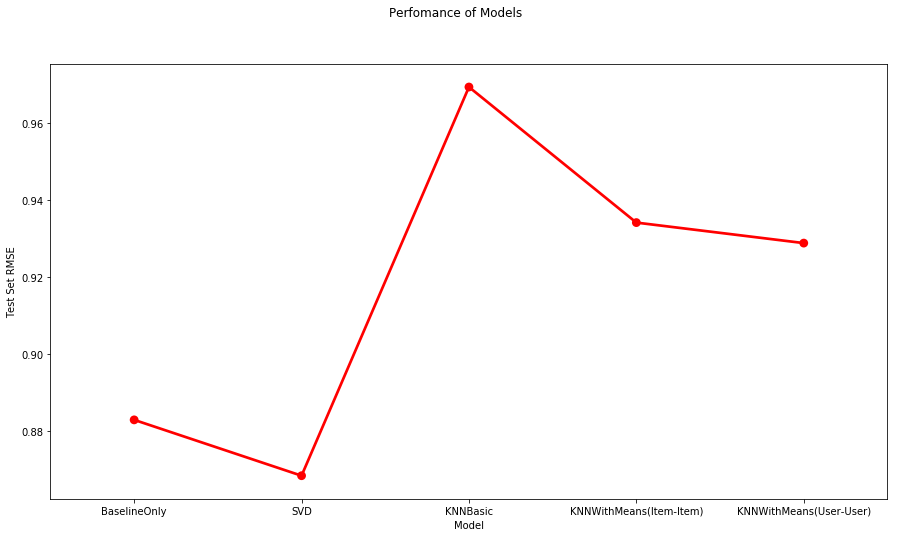

In [50]:
fig = plt.figure(figsize=(15,8))
fig.suptitle('Perfomance of Models')
ax = fig.add_subplot(111)
comp_graph = sns.pointplot(x=final_compare_df['Model'], y=final_compare_df['Test Set RMSE'], 
                           data=final_compare_df,scale=1, color='red')
plt.show()

From this above graph plotting, we can see the RMSE scores of the evaluated models and SVD is best among all as it has the lowest RMSE.

<b><u>Recommend New Products Using SVD Model : </u></b>

In [51]:
# Defining functions to find top k number of recommendation
def get_top_n(predictions, n=k):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [52]:
startTimestamp = time.time()
top_n = get_top_n(svd_predictions, n=k)
endTimestamp = time.time()
print("This took %.2f seconds" % (endTimestamp - startTimestamp))

This took 0.01 seconds


In [53]:
uId = []
recommand = []
for uid, user_ratings in top_n.items():
    uId.append(uid)
    recommand.append([iid for (iid, _) in user_ratings])
    
recommand_df = pd.DataFrame({'UserId': uId, 'Top 5 Recommended Product\'s Id': recommand})
pd.set_option('max_colwidth', 800)
print("BELOW ARE PRODUCT RECOMMENDATION FOR USERS: ")
recommand_df

BELOW ARE PRODUCT RECOMMENDATION FOR USERS: 


,UserId,Top 5 Recommended Product's Id
0,A1RL1OTV8IJMVD,"[B005ELBSWO, B005DQG5SC, B00EOE4G4E, B002FU5QMA, B004HKJTT2]"
1,AVSMRPI23DQI2,"[B0007QKMQY, B000MQNMQ6, B002C7481G]"
2,A1H7Y5XKPGT0OS,"[B006ZT4VA0, B000BQ7GW8, B008EQYRRY, B009NHWVIA, B001W28L2Y]"
3,A3S3R88HA0HZG3,"[B001TUYTZM, B003ES5ZUU, B00316263Y, B00BYRPM9M, B005FDXZJU]"
4,A3SL0HA6422W4M,"[B007WTAJTO, B005HSDLCO, B003VNKKUS]"
5,A145B8OHVNNFAJ,"[B00G4UQ6U8, B00EDCF0MY, B00EVWX8R0, B00DR6DQZA, B00G4V0QSK]"
6,A3F7USIDJBR8WU,"[B004LSNF04, B000L47AHG]"
7,AYGEKID3G7DPW,"[B006QB1RPY, B004K1EZDS, B00691WMJG, B005FDXMJS, B008R7EVE4]"
8,A240FRPD4MEXND,"[B00HG1L334, B0082E9K7U, B004BQTTE2, B003VAK16O, B00829THVO]"
9,A25UZ7MA72SMKM,"[B000N99BBC, B000BQ7GW8, B003CFATT2, B003DZJQQI, B006LW0W5Y]"


So here we displayed the top 5 recommended products for each user based on SVD prediction data.

<hr>
Towards the end I can say that after checking the dataset, all the data analysis, we created the best subset of data by filtering out the low count of user ratings and products and minimised the `Greysheep` problem. 


<b><u>Poluparity Based Model</u></b>

Then evaluating the popularity based model with manual sorting process and using rank function. Popularity Based Recommender model is the top rated products recommender. So for every user users same products wil be recommended. And we evaluated the models with top 5 products based on rating and ranking.

As popularity recommendation is non-personalised recommendation, we get top products for all the users. We picked three user having id `A34VRVI4CSI5RQ`, `AHROSV6WJOEGY` and `A2G563AC1HME2R` and tried to predict the recommendation for them and we got all same top products for them and which is having productId 

 - `B0088CJT4U`
 - `B003ES5ZUU`
 - `B000N99BBC`
 - `B007WTAJTO`
 - `B00829TIEK`

<b><u>Collaborative Filtering Model</u></b>

Built 5 model for the collaborative recommendation, hypertune the parameters of the models and evaluated the RMSE score and found the best working model on test data and verified with cross validation. Test and cross validation RMSE score deviation is also less.

<b>Found SVD is the best working model.</b> But BaselineOnly model is our second best evaluated model which scored almost same as SVD and performing same.

<b><u>SVD Model Score</u></b>
* RMES score is `0.8684`
* MAE score is `0.6517` 

    <u>Cross Validation</u>
    * Mean RMSE of 5 fold is `0.8764`
    * Standard deviation of `0.0061`

<b><u>BaselineOnly Model Score</u></b>
* RMES score is `0.8829`
* MAE score is `0.6413`

    <u>Cross Validation</u>
    * Mean RMSE of 5 fold is `0.8838`
    * Standard deviation of `0.0076`

Lastly as per our objective we got our top k (k=5) recommended products as well.

<hr>
<b>Suggession: </b>

 * We should always keep ready 3-4 models for .
 * We can improve further model performance but we might need some deep learning technique for that.


### <center>============================ X ============================</center>